In [119]:
import numpy as np
import matplotlib.pyplot as plt

# set seed for reproducibility
random_state = np.random.seed(7)

# We need to create a line for 3.7 and a sine wave for 3.8
# x is our input variable or feature
# t is our target variable or output

def generate_sine_data(n, noise=0.2):
    x = np.random.uniform(-1, 1, n) # same as before
    t = np.sin(2*np.pi*x) + np.random.normal(0, noise, n) # generates t values from a sine wave t = sin(2*pi*x)
    return x, t

In [120]:

def compute_kernel(xi, xj, lengthscale):
    # Assuming Gaussian kernel eq. 6.23
    return np.exp(-np.linalg.norm(xi - xj)**2 / (2 * lengthscale**2))

def gp_prediction(train_x, test_x, train_t):
    # equations 6.66 and 6.67

    # assuming our data noise = 0.2
    noise = 0.2 # variance
    lengthscale = 0.2 #this parameter controls how "similar" two inputs are

    n = len(train_x)
    cov_matrix = np.empty((n+1,n+1))

    # Creating the C_N-1 Block
    for i in range(n):
        for j in range (i, n):
            cov_matrix[i, j] = compute_kernel(train_x[i], train_x[j], lengthscale)
            cov_matrix[j, i] = cov_matrix[i, j]
            if (i == j):
                cov_matrix[j,j] += noise # we add diagonal noise matrix since our assumption with y = f(x) + epsilon where epsilon follows a normal dist.

    # Creating the c "scalar"
    cov_matrix[n, n] = compute_kernel(test_x, test_x, lengthscale) + noise

    # Creating K-block
    for k in range(n):
        cov_matrix[n, k] = compute_kernel(test_x, train_x[k], lengthscale)
        cov_matrix[k, n] = cov_matrix[n, k]

    k = cov_matrix[n, :n]  #1 x n-1 vector for k
    old_C = cov_matrix[:n, :n] #n-1 x n-1 cov matrix for old targets
    c = cov_matrix[n,n] # 1x1 scalar for c

    mean = k @ np.linalg.inv(old_C) @ train_t
    variance = c - k @ np.linalg.inv(old_C) @ np.transpose(k)  # variance, basically how uncertain we are about these predictions
    return mean, variance

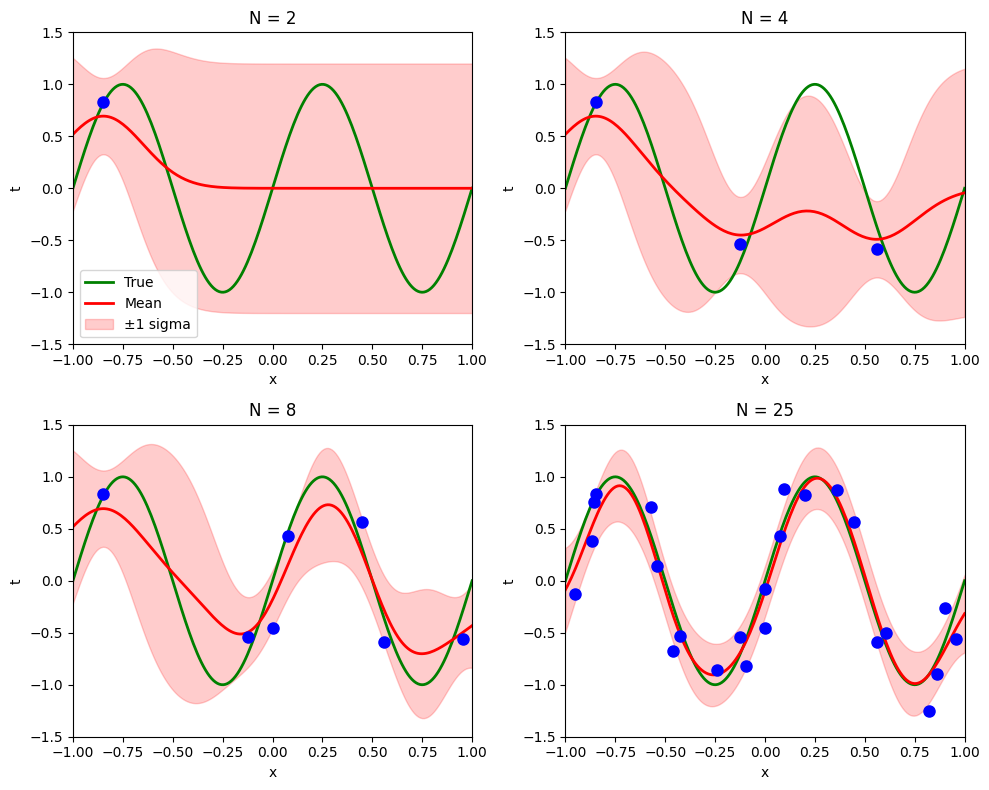

In [121]:
def figure_3_8():
    x_data, t_data = generate_sine_data(25) # get 25 points from the t = sin(...) + noise

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for idx, n in enumerate([2, 4, 8, 25]):
        train_x = x_data[:n-1]
        train_t = t_data[:n-1]
        test_x = x_data[n-1]

        x_plot = np.linspace(-1, 1, 200) # here we plot the 200 evenly spaced x values
        means, stds = [], []

        #for each point in the plot, predict what the gp thinks the function looks like
        for new_x in x_plot:
            m_N, S_N = gp_prediction(train_x, new_x, train_t)
            # means is our "expected function" and  S_N is our model uncertainty with what the function looks like at a particular area each time randomly sample one new point
            means.append(m_N)
            # uncertainty for our expected function at certain points
            stds.append(S_N)

        means = np.array(means)
        stds = np.array(stds)

        # Plot true sine wave
        axes[idx].plot(x_plot, np.sin(2*np.pi*x_plot), 'g-', lw=2, label='True')

        #Plot posterior mean
        axes[idx].plot(x_plot, means, 'r-', lw=2, label='Mean')

        #Confidence bands
        axes[idx].fill_between(x_plot, means-stds, means+stds, color='r', alpha=0.2, label='±1 sigma')

        #Training points
        axes[idx].plot(x_data[:n-1], t_data[:n-1], 'bo', ms=8)
        axes[idx].set_xlim(-1, 1)
        axes[idx].set_ylim(-1.5, 1.5)
        axes[idx].set_title(f'N = {n}')
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('t')
        if idx == 0:
            axes[idx].legend()

    plt.tight_layout()
    plt.show()

figure_3_8()

In [122]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X_uci = breast_cancer_wisconsin_diagnostic.data.features
y_uci = breast_cancer_wisconsin_diagnostic.data.targets

# Convert pandas data to numpy arrays
X_bdata = X_uci.to_numpy()

y = y_uci['Diagnosis'].to_numpy()
y_bdata = np.where(y == 'M', 1, 0) #Convert M or B to 1/0 for classification)

# train test split using sci-kit learn
# 80% training, 20% test
test_size = 0.2
X_bdata_train, X_bdata_test, y_bdata_train, y_bdata_test = train_test_split(X_bdata, y_bdata, test_size=test_size, random_state=random_state, stratify=y_bdata)

In [123]:
# see count of 0/1 labels to choose scoring metric (see distribution of results)
print("Train: zeros, ones", np.bincount(y_bdata_train))
print("Test: zeros, ones", np.bincount(y_bdata_test))

Train: zeros, ones [285 170]
Test: zeros, ones [72 42]


In [124]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# took inspiration from https://www.kaggle.com/code/viznrvn/optimal-parameters-for-svc-using-gridsearch

# k-fold cross validation
# using stratified k-fold which makes the distribution within each fold even
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# parameter grid
param_grid = {
    # regularization strength => large = heavier penalization
    'C': [1, 1e1, 1e2, 1e3, 1e4, 1e5],

    # # RBF kernel width => large = very local influence (overfit risk), small = broad influence (underfit risk)
    'gamma': [1e-1, 1e-3, 1e-5, 1e-7],
}

# scoring metrics here: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
# using ROC-AUC as opposed to something like f1 as data is imbalanced and want to
# eval the model's performance across a lot of thresholds
gs = GridSearchCV(
    SVC(kernel='rbf', probability=True),
    param_grid,
    cv=cv,
    scoring="roc_auc",
    # verbose=2,
)
gs.fit(X_bdata_train, y_bdata_train)
print("Best params:", gs.best_params_)

# AUC (area under the ROC curve), averaged across the CV folds
print("avg CV ROC AUC:", gs.best_score_)

svm = gs.best_estimator_
y_hat_train = svm.predict(X_bdata_train)
print("Train Accuracy:", accuracy_score(y_bdata_train, y_hat_train))

y_hat_test = svm.predict(X_bdata_test)
print("Test Accuracy:", accuracy_score(y_bdata_test, y_hat_test))

print(classification_report(y_bdata_test,y_hat_test))

Best params: {'C': 100.0, 'gamma': 1e-05}
avg CV ROC AUC: 0.9906088751289989
Train Accuracy: 0.9692307692307692
Test Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.93      0.95      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



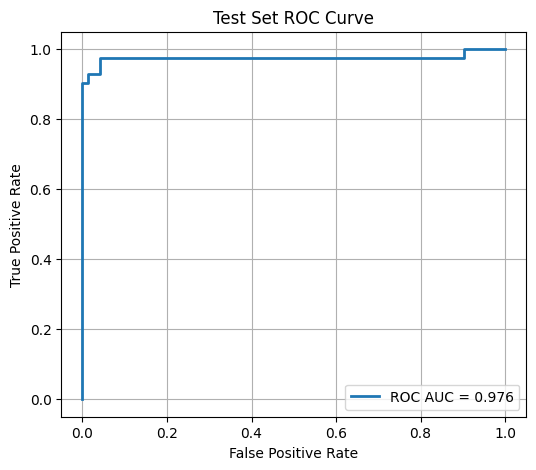

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# given an input, return probability estimate for each class
y_proba_test = svm.predict_proba(X_bdata_test)[:, 1]

# generate ROC curve and AUC value
# looks "blocky" as we don't have a lot of test points (~100 total)
fpr, tpr, roc_thresh = roc_curve(y_bdata_test, y_proba_test, pos_label=1)
roc_auc = roc_auc_score(y_bdata_test, y_proba_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set ROC Curve")
plt.legend()
plt.grid(True)
plt.show()